# SciPy Proceedings 2017: "ChiantiPy: A Python Package for Astrophysical Spectroscopy"
This notebook provides the source to build all of the figures for the SciPy 2017 proceedings paper on ChiantiPy.

In [1]:
import os
import glob

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import ticker
import seaborn.apionly as sns
import pandas as pd
import periodictable
import roman
import ads

import ChiantiPy.core as ch
import ChiantiPy.tools.util as ch_util
import ChiantiPy.tools.data as ch_data
import ChiantiPy.tools.io as ch_io
import ChiantiPy.tools.filters as ch_filters

#sns.set_context('paper',
#                rc={prop:plt.rcParams[prop] for prop in ['lines.linewidth','axes.titlesize','axes.labelsize',
#                                                         'xtick.labelsize','ytick.labelsize']})
sns.set_style('white')
sns.set_palette('deep')
with open('/home/wtb2/.ads/dev_key','r') as f:
    ads.config.token = f.read()
%matplotlib inline

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


 using cli
 using CLI for selections
 reading chiantirc file


## Papers and Citations

In [ ]:
bibcodes = ['1997A&AS..125..149D','1998A&A...329..291Y','1999A&AS..135..339L','2001ApJS..134..331D',
            '2002ApJS..139..281L','2003ApJS..144..135Y','2006ApJS..162..261L','2006ApJS..166..421L',
            '2009A&A...498..915D','2009ApJ...706....1L','2009ApJ...707..173Y','2012ApJ...744...99L',
            '2013ApJ...763...86L','2015A&A...582A..56D','2016JPhB...49g4009Y']

In [ ]:
ch_papers = [list(ads.SearchQuery(bibcode=bibcode,fl=['title','author','year','citation_count','citation']))[0] for bibcode in bibcodes]

In [ ]:
for chp in ch_papers:
    print('{} ({}) -- {}'.format(chp.author[0],chp.year,chp.citation_count))

In [ ]:
sum([p.citation_count for p in ch_papers])

In [ ]:
year_list = [int(cp[:4]) for p in ch_papers for cp in p.citation]

In [ ]:
citation_bib_codes = [cp for p in ch_papers for cp in p.citation]

In [ ]:
cited_papers = [list(ads.SearchQuery(bibcode=bc,fl=['author','title','year','keyword']))[0] for bc in citation_bib_codes]

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
hist,bin_edges,_ = ax.hist(year_list,bins = np.arange(1997,2018,1),alpha=0.5)
#ax.set_xticks([be for be in bin_edges])
#ax.set_xticklabels([be for be in bin_edges if be%2==0])
ax2 = ax.twinx()
ax2.hist(year_list,bins = np.arange(1997,2018,1),histtype='step',color=sns.color_palette()[2],cumulative=True,lw=2)
#ax.set_yscale('log')

## Database

Make a heatmap showing all of the ions in the CHIANTI database and the associated number of levels. Probably best to build a pandas dataframe first.

In [ ]:
ion_list = []
exclude_dirs = ['abundance','ancillary_data','continuum','dem','ioneq','ip','masterlist','VERSION']

In [ ]:
for top_dir in glob.glob('/usr/local/ssw/packages/chianti/dbase/*'):
    if os.path.basename(top_dir) not in exclude_dirs:
        for sub_dir in glob.glob(os.path.join(top_dir,'*')):
            ion = os.path.basename(sub_dir)
            if ion[-1] == 'd':
                continue
            elvlc = ch_io.elvlcRead(ion)
            if elvlc['status'] == 0:
                continue
            num_levels = np.max(elvlc['lvl'])
            tmp_name = ch_util.zion2spectroscopic(ch_util.el2z(ion.split('_')[0]),int(ion.split('_')[1]))
            element = list(filter(None,tmp_name.split(' ')))[0]
            stage = list(filter(None,tmp_name.split(' ')))[1]
            ion_list.append({'Element':element,'Stage':stage,'Levels':num_levels})

In [ ]:
ion_table = pd.DataFrame(ion_list)
ion_table_pivot = ion_table.pivot('Element','Stage','Levels')
new_indices = sorted(ion_table_pivot.index, key=lambda x:periodictable.elements.symbol(x).number)
ion_table_pivot = ion_table_pivot.reindex(new_indices)
ion_table_pivot = ion_table_pivot.reindex_axis(sorted(ion_table_pivot.columns.tolist(),key=lambda x:roman.fromRoman(x)),axis=1)

In [ ]:
fig = plt.figure(figsize=(16,5))
my_cmap = plt.get_cmap('Blues')
my_cmap.set_bad(color='w')
sns.heatmap(ion_table_pivot,ax=fig.gca(),square=False,cmap=my_cmap,
            annot=True,fmt='.0f',
            norm=matplotlib.colors.LogNorm(vmin=1,vmax=1e3),
            cbar_kws={'ticks':[1,10,100,1000]},
            cbar=False
           )
plt.savefig('figures/linelist.pdf',dpi=1000,format='pdf',bbox_inches='tight')

In [ ]:
def linear_fit(x,a,b):
    return b*x**a

In [ ]:
foo = ch_io.wgfaRead(tmp_ion)
bar = ch_io.elvlcRead(tmp_ion)
delta_energies = np.array(bar['ecm'])[np.array(foo['lvl2'],np.int) - 1] - np.array(bar['ecm'])[np.array(foo['lvl1'],np.int) - 1]
wvl_cm = np.array(foo['wvl'])/1e8
wvl_smooth = np.linspace(wvl_cm.min(),wvl_cm.max(),100)
#delta_energys *= ch_data.
popt,pcov = curve_fit(linear_fit,wvl_cm,delta_energies)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.plot(wvl_cm,delta_energies,'o',label=tmp_ion,markersize=15,alpha=0.3)
ax.plot(wvl_smooth,linear_fit(wvl_smooth,*popt),'--r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$\Delta E$ (cm$^{-1}$)')
ax.set_xlabel(r'Wavelength (cm)')

In [ ]:
spd_ticklabels = sorted(set([(a,b) for a,b in zip(bar['l'],bar['spd'])]),key=lambda x:x[0])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in range(len(foo['wvl'])):
    l1,e1 = bar['l'][foo['lvl1'][i]-1],bar['eryd'][foo['lvl1'][i]-1]
    l2,e2 = bar['l'][foo['lvl2'][i]-1],bar['eryd'][foo['lvl2'][i]-1]
    ax.scatter(l1,e1,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.scatter(l2,e2,
               marker='_',color=sns.color_palette('deep')[0],s=10)
    ax.annotate(foo['pretty2'][i],
                xy=(l1,e1), xycoords='data',
                xytext=(l2,e2), textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3"),)
    ax.text(l1,e1,foo['pretty1'][i])
ax.set_xticks([x[0] for x in spd_ticklabels])
ax.set_xticklabels([x[1] for x in spd_ticklabels])
#ax.set_ylim([1.3,2])
ax.set_xlabel(r'Orbital')
ax.set_ylabel(r'Energy (Rydbergs)')

## Line Emission

In [90]:
fe_ion = ch.ion('fe_5',np.logspace(4,8,100),eDensity=1e9)

### Emissivity and Level Populations

Show plot of populations for a sample ion and a plot of emissivities for a sample ion. These should be as a function of wavelength and temperature/density. We'll probably just use Fe for all of the examples to make things easy.

In [91]:
fe_ion.populate()

In [92]:
fe_ion.Population['population'].shape

(100, 34)

(10000.0, 100000000.0)

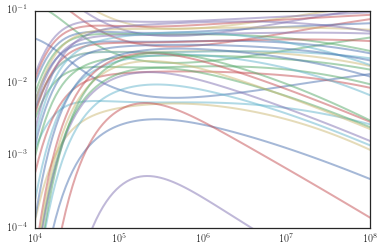

In [93]:
fig = plt.figure()
ax = fig.gca()
for i in fe_ion.Elvlc['lvl']:
    ax.plot(fe_ion.Temperature,fe_ion.Population['population'][:,i-1],alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,0.1])
ax.set_xlim([fe_ion.Temperature.min(),fe_ion.Temperature.max()])

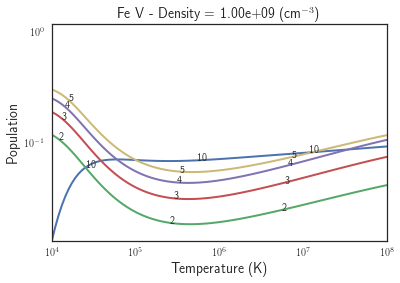

In [94]:
fe_ion.popPlot(top=5)

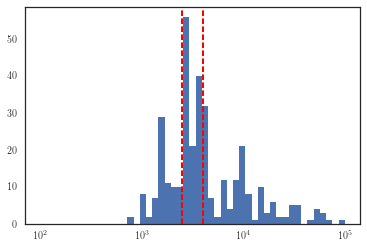

In [103]:
_,_,_ = plt.hist(fe_ion.Wgfa['wvl'],np.logspace(2,5,50))
plt.xscale('log')
plt.axvline(x=2500,c='r',ls='--')
plt.axvline(x=4000,c='r',ls='--')

### Contribution Functions
First, the contribution function function in the ion class needs to be refactored. But then we should show the contribution function for a couple of ions.

### Spectrum

In [286]:
wavelength = np.arange(2600,2900,0.1)

In [287]:
spectra = {}
sigma,gamma,width = 5,5,5
for i,(fil,fac,lab) in enumerate([(ch_filters.gaussian,5,'Gaussian, $\sigma={}\,\,\mathrm{{\mathring{{A}}}}$'.format(sigma)),
                                  (ch_filters.lorentz,5,'Lorentzian, $\gamma={}\,\,\mathrm{{\mathring{{A}}}}$'.format(gamma)),
                                  #(ch_filters.boxcar,5,'Boxcar, $w={}\,\,\mathrm{{\mathring{{A}}}}$'.format(width))]
                                 ]):
    fe_ion.spectrum(wavelength,filter=(fil,fac))
    spectra[lab] = (fe_ion.Spectrum['wvl'],fe_ion.Spectrum['intensity'])

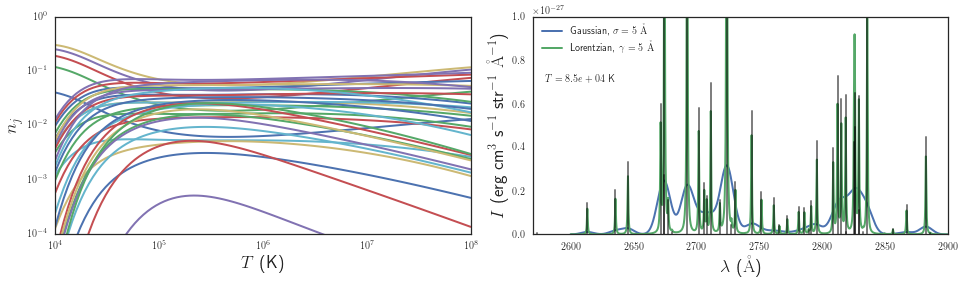

In [288]:
fig,axes = plt.subplots(1,2,figsize=(16,4))
# level populations
for i in fe_ion.Elvlc['lvl']:
    axes[0].plot(fe_ion.Temperature,fe_ion.Population['population'][:,i-1])
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim([1e-4,1.])
axes[0].set_xlim([fe_ion.Temperature.min(),fe_ion.Temperature.max()])
# spectra and intensity
for key in spectra:
    axes[1].plot(spectra[key][0],spectra[key][1][np.argmax(fe_ion.IoneqOne),:],
            label=key)
for w,intensity in zip(fe_ion.Intensity['wvl'],fe_ion.Intensity['intensity'][np.argmax(fe_ion.IoneqOne),:]):
    axes[1].plot([w,w],[0,intensity],color='k',alpha=0.5)
axes[1].text(2580,0.7e-27,'$T = {:.2g}$ K'.format(fe_ion.Temperature[np.argmax(fe_ion.IoneqOne)]))
axes[1].legend(loc='best')
axes[1].set_xlim([2570,2900])
axes[1].set_ylim([0,1e-27])
# labels
axes[0].set_xlabel(r'$T$ (K)')
axes[1].set_xlabel(r'$\lambda$ ($\mathrm{\mathring{A}}$)')
axes[0].set_ylabel(r'$n_j$')
axes[1].set_ylabel(r'$I$ (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
plt.subplots_adjust(wspace=0.15)
plt.savefig('figures/pop_and_spectrum.pdf',dpi=1000,format='pdf',bbox_inches='tight')

In [139]:
fe_ion.intensityList()

using index =    50 specifying temperature =   1.05e+06, eDensity =    1.00e+09 em =   1.00e+00
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
 fe_5    24    34             3d4 (2) 1D2.0 - 3d4 (1) 1S0.0                1336.2020    3.243e-36     6.24e+01 Y
 fe_5    18    33             3d4 (2) 1G4.0 - 3d4 (1) 1D2.0                1746.8470    1.432e-35     3.22e+01 Y
 fe_5    24    33             3d4 (2) 1D2.0 - 3d4 (1) 1D2.0                2103.4430    2.794e-36     7.56e+00 Y
 fe_5     7    28                 3d4 3H4.0 - 3d4 (1) 3F2.0                2674.6120    3.633e-36     3.37e+00 Y
 fe_5     9    29                 3d4 3H5.0 - 3d4 (1) 3F3.0                2692.6240    4.647e-36     3.00e+00 Y
 fe_5    10    27                 3d4 3H6.0 - 3d4 (1) 3F4.0                2724.0830    6.295e-36     3.21e+00 Y
 fe_5    14    27             3d4 (2) 3F4.0 - 3d4 (1) 3F4.0

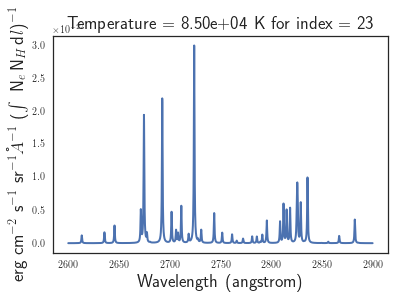

In [171]:
fe_ion.spectrumPlot(index=np.argmax(fe_ion.IoneqOne))

## Continuum Emission
Free-free, free-bound, two-photon

In [282]:
wavelength = np.logspace(0,3,100)
temperature = np.logspace(6,8.5,100)
fe18_continuum = ch.Continuum('fe_18',temperature)

### Free-free

In [283]:
fe18_continuum.calculate_free_free_emission(wavelength)

In [284]:
fe18_continuum.calculate_free_bound_emission(wavelength)

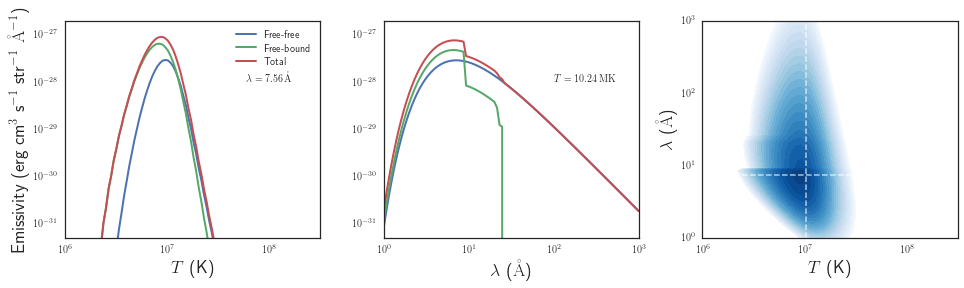

In [285]:
wmesh,tmesh = np.meshgrid(wavelength,temperature)
fig,axes = plt.subplots(1,3,figsize=(16,4))
# Temperature
axes[0].plot(temperature,fe18_continuum.free_free_emission[:,29],label=r'Free-free')
axes[0].plot(temperature,fe18_continuum.free_bound_emission[:,29],label=r'Free-bound')
axes[0].plot(temperature,(fe18_continuum.free_bound_emission[:,29]
                          + fe18_continuum.free_free_emission[:,29]),label=r'Total')
axes[0].text(6e7,1e-28,r'$\lambda={:.2f}\,\mathrm{{\mathring{{A}}}}$'.format(wavelength[29]))
axes[0].legend(loc=1)
axes[0].set_xlabel(r'$T$ (K)')
axes[0].set_ylabel(r'Emissivity (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_ylim([5e-32,2e-27])
axes[0].set_xlim([temperature[0],temperature[-1]])
# Wavelength
axes[1].plot(wavelength,fe18_continuum.free_free_emission[40,:])
axes[1].plot(wavelength,fe18_continuum.free_bound_emission[40,:])
axes[1].plot(wavelength,(fe18_continuum.free_bound_emission[40,:]
                     + fe18_continuum.free_free_emission[40,:]))
axes[1].text(1e2,1e-28,r'$T={:.2f}\,\mathrm{{MK}}$'.format(temperature[40]/1e6))
axes[1].set_xlabel(r'$\lambda$ ($\mathrm{\mathring{A}}$)')
#axes[1].set_ylabel(r'Emissivity (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim([5e-32,2e-27])
axes[1].set_xlim([wavelength[0],wavelength[-1]])
# 2D
custom_cmap = plt.get_cmap('Blues')
custom_cmap.set_bad('w')
im = axes[2].contourf(tmesh,wmesh,
               fe18_continuum.free_free_emission+fe18_continuum.free_bound_emission,
               cmap=custom_cmap,
                     norm=matplotlib.colors.LogNorm(vmin=5e-32,vmax=2e-27),
                     #locator=ticker.LogLocator(),
                     levels=np.logspace(np.log10(5e-32),np.log10(2e-27),25),
                    )
axes[2].axvline(x=temperature[40],ls='--',color='w',alpha=0.5,lw=2.)
axes[2].axhline(y=wavelength[29],ls='--',color='w',alpha=0.5,lw=2.)
axes[2].set_xlabel(r'$T$ (K)')
axes[2].set_ylabel(r'$\lambda$ ($\mathrm{\mathring{A}}$)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
#fig.colorbar(im,ax=axes[2])
#plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/continuum.pdf',dpi=1000,format='pdf',bbox_inches='tight')

## Ionization Equilibrium
Include some equations that describe the ionization equilibrium.

First figure shows a comparison between the loaded data of the latest CHIANTI ionization equilibrium file and an older Mazzotta file. This figure may not be used at all.

In [ ]:
fe_ioneq_chianti = ch.ioneq('Fe')
fe_ioneq_chianti.load()
fe_ioneq_mazzotta = ch.ioneq('Fe')
fe_ioneq_mazzotta.load(ioneqName='mazzotta_etal')

In [ ]:
fig = plt.figure(figsize=(11.2,8))
ax = fig.gca()
colors = sns.color_palette(n_colors=fe_ioneq_chianti.Ioneq.shape[0])
for i in range(fe_ioneq_chianti.Ioneq.shape[0]):
    ax.plot(fe_ioneq_chianti.Temperature,fe_ioneq_chianti.Ioneq[i,:],
            label=roman.toRoman(i+1),
            color=colors[i]
           )
    ax.plot(fe_ioneq_mazzotta.Temperature,fe_ioneq_mazzotta.Ioneq[i,:],
            color=colors[i],
            ls='--'
           )
    
ax.set_xscale('log')
ax.set_ylim([0,1.01])
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$N(X_i)/N(X)$')
ax.set_xlim([temperature[0],temperature[-1]])
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=9)
sns.despine(fig=fig,ax=ax)

This second figure shows the ionization equilibrium calculated over a custom temperature range for four different elements.

In [ ]:
els = ['H','Na','S','Fe']
temperature = np.logspace(3.5,9.5,500)
ioneqs = {el:{'calc':{'temperature':temperature},'data':{}} for el in els}
for el in els:
    tmp_ioneq = ch.ioneq(el)
    tmp_ioneq.calculate(temperature)
    ioneqs[el]['calc']['ioneq'] = tmp_ioneq.Ioneq
    tmp_ioneq_data = ch.ioneq(el)
    tmp_ioneq_data.load(ioneqName='mazzotta_etal')
    ioneqs[el]['data']['temperature'] = tmp_ioneq_data.Temperature
    ioneqs[el]['data']['ioneq'] = tmp_ioneq_data.Ioneq

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
for ax,el in zip(axes.flatten(),els):
    colors = sns.color_palette(n_colors=ioneqs[el]['calc']['ioneq'].shape[0])
    for i in range(ioneqs[el]['calc']['ioneq'].shape[0]):
        ax.plot(ioneqs[el]['calc']['temperature'],ioneqs[el]['calc']['ioneq'][i,:],color=colors[i],ls='-')
        #ax.plot(ioneqs[el]['data']['temperature'],ioneqs[el]['data']['ioneq'][i,:],color=colors[i],ls='--')
    ax.set_xscale('log')
    ax.set_ylim([0.01,1.02])
    ax.set_xlim([temperature[0],temperature[-1]])
    if axes.flatten().tolist().index(ax) > 1:
        ax.set_xlabel(r'$T$ (K)')
    if axes.flatten().tolist().index(ax)%2 == 0:
        ax.set_ylabel(r'$X_i$')
plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('figures/ioneq.pdf',dpi=1000,format='pdf',bbox_inches='tight')

## Radiative Losses

In [231]:
temperature = np.logspace(4,8,100)
density = 1e9
radiative_loss = ch.radLoss(temperature,density,minAbund=1e-4,keepIons=True)

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev501-py3.5.egg/ChiantiPy/core/Continuum.py:109: RuntimeWarning: divide by zero encountered in log
  gaunt_factor = splev(np.log(gamma_squared),


 elapsed seconds =   6.60e+02


In [237]:
radiative_loss_photosphere = ch.radLoss(temperature,density,minAbund=1e-6,abundance='sun_photospheric_2009_asplund')

/home/wtb2/anaconda3/envs/chiantipy/lib/python3.5/site-packages/ChiantiPy-0.7.dev501-py3.5.egg/ChiantiPy/core/Continuum.py:109: RuntimeWarning: divide by zero encountered in log
  gaunt_factor = splev(np.log(gamma_squared),


 elapsed seconds =   1.16e+03


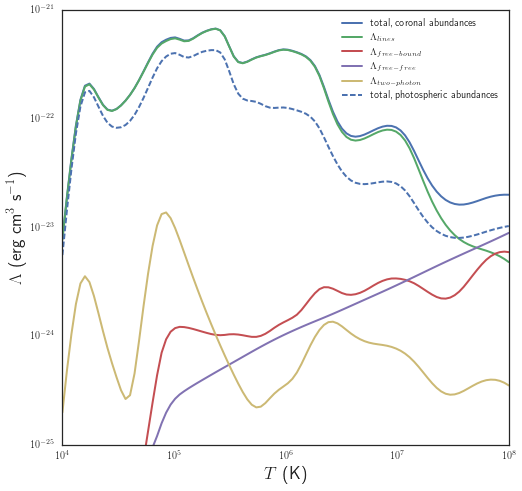

In [241]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
# coronal abundances
ax.plot(temperature,radiative_loss.RadLoss['rate'],
        color=sns.color_palette()[0],
        label=r'total, coronal abundances')
ax.plot(temperature,radiative_loss.BoundBoundLoss,
        color=sns.color_palette()[1],
        label=r'$\Lambda_{lines}$')
ax.plot(temperature,radiative_loss.FreeBoundLoss,
        color=sns.color_palette()[2],
        label=r'$\Lambda_{free-bound}$')
ax.plot(temperature,radiative_loss.FreeFreeLoss,
        color=sns.color_palette()[3],
        label=r'$\Lambda_{free-free}$')
ax.plot(temperature,radiative_loss.TwoPhotonLoss,
        color=sns.color_palette()[4],
        label=r'$\Lambda_{two-photon}$')
# photospheric abundances
ax.plot(temperature,radiative_loss_photosphere.RadLoss['rate'],
        color=sns.color_palette()[0],ls='--',label=r'total, photospheric abundances')
# limits and scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-25,1e-21])
ax.set_xlim([temperature[0],temperature[-1]])
# labels
ax.set_xlabel(r'$T$ (K)')
ax.set_ylabel(r'$\Lambda$ (erg cm$^{3}$ s$^{-1}$)')
ax.legend(loc='best')
plt.savefig('figures/rad_loss.pdf',dpi=1000,format='pdf',bbox_inches='tight')

## Spectra

In [257]:
temperature_1 = np.array([1e+6,4e+6,1e+7])
density = 1e+9
wavelength = np.linspace(10,100,1000)
min_abund = 1e-4
spec = ch.spectrum(temperature_1, density, wavelength, minAbund=min_abund)

 elapsed seconds =      288.000


In [327]:
i_wvl_select = np.where(np.logical_and(spec.Intensity['wvl']>=30,
                                       spec.Intensity['wvl']<=100))
wvl_select = spec.Intensity['wvl'][i_wvl_select]
int_select = spec.Intensity['integrated'][i_wvl_select]
ions_select = spec.Intensity['ionS'][i_wvl_select]
wvl_select = wvl_select[np.argsort(int_select)[::-1]]
int_select = np.sort(int_select)[::-1]
ions_select = ions_select[np.argsort(int_select)[::-1]]

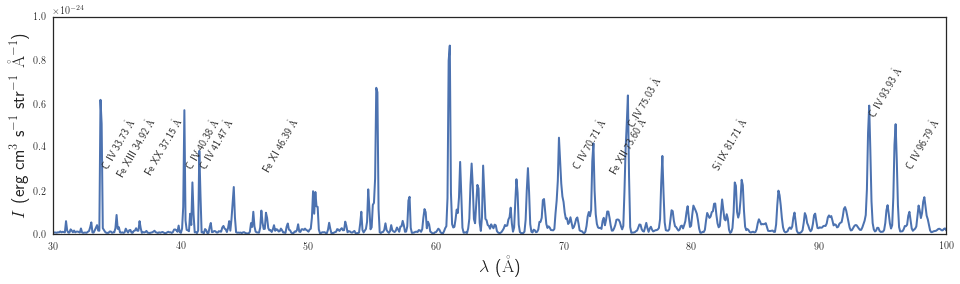

In [377]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(spec.Spectrum['wavelength'],spec.Spectrum['integrated'])
# label some lines
for i in [0,1,5,10,100,500,1000,5000,10000,20000,100000,-1]:#range(0,len(int_select),5000):
    spec_lab = ch_util.zion2spectroscopic(ch_util.el2z(ions_select[i].split('_')[0]),
                                          int(ions_select[i].split('_')[1]))
    ax.text(wvl_select[i],max(5.e-25,7.*int_select[i]),
            '{} {:.2f} $\mathrm{{\mathring{{A}}}}$'.format(spec_lab,wvl_select[i]),rotation=60)
ax.set_xlabel(r'$\lambda$ ($\mathrm{\mathring{A}}$)')
ax.set_ylabel(r'$I$ (erg cm$^{3}$ s$^{-1}$ str$^{-1}$ $\mathrm{\mathring{A}}^{-1}$)')
ax.set_ylim([0,1e-24])
ax.set_xlim([30,100])
plt.savefig('figures/total_spectrum.pdf',dpi=1000,format='pdf',bbox_inches='tight')

In [310]:
spec.intensityList(wvlRange=[30,100],top=20)

using index =     1 specifying temperature =    4.00e+06
   
 ------------------------------------------
   
  Ion  lvl1  lvl2                     lower - upper                           Wvl(A)    Intensity      A value Obs
  c_6     1     4                  1s 2S0.5 - 2p 2P1.5                       33.7342    1.568e-26     8.12e+11 Y
  c_6     1     3                  1s 2S0.5 - 2p 2P0.5                       33.7396    9.823e-27     8.12e+11 Y
si_12     1     6              1s2.2s 2S0.5 - 1s2.3p 2P1.5                   40.9110    1.342e-26     4.47e+11 Y
si_12     2     7              1s2.2p 2P0.5 - 1s2.3d 2D1.5                   44.0194    1.007e-26     1.16e+12 Y
si_12     3     8              1s2.2p 2P1.5 - 1s2.3d 2D2.5                   44.1650    1.806e-26     1.37e+12 Y
si_12     3     4              1s2.2p 2P1.5 - 1s2.3s 2S0.5                   45.6910    9.194e-27     1.33e+11 Y
fe_16     1     8                  3s 2S0.5 - 4p 2P1.5                       50.3610    1.913e-26 